In [1]:
import pandas as pd
from transformers import BertTokenizer, BertModel
from sklearn.cluster import KMeans
import torch
import numpy as np
import matplotlib.pyplot as plt
import re
import json
import tqdm

2023-12-14 13:23:31.586127: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-14 13:23:32.138931: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-14 13:23:33.158767: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-12-14 13:23:33.158874: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [22]:
# Read the data
csv_path = 'data/ckeditor5_issues.csv'
df = pd.read_csv(csv_path)
owner, name = df['Repo Owner'][0], df['Repo Name'][0]

In [23]:
def extract_issue_ref(text):
    """Takes text as the input
    Returns the issue references mentioned in the input text"""
    if not isinstance(text, str):
        # If text is not a string, make it a string
        text = str(text)

    issue_url_regex = r'/' + owner + r'/' + name + r'/issues/(\d+)'
    matches = re.findall(issue_url_regex, text)
    issue_numbers_http = set([match for match in matches])

    edge_regex =  r'' + owner + r'/' + name + r'#(\d+)'
    matches = re.findall(edge_regex, text)
    issue_numbers_edge = set([match for match in matches])

    task_regex =  r'\[([xX]|\s)\]\s?#(\d+)'
    matches = re.findall(task_regex, text)
    issue_numbers_hashtag = set([match[1] for match in matches])


    return set(list(issue_numbers_edge) + list(issue_numbers_http) + list(issue_numbers_hashtag))

In [24]:
# Extract issue references from the issue bodies
df['References'] = df.apply(lambda row: (list(set(extract_issue_ref(row['Issue Body'])))), axis=1)

In [25]:
# Construct the epic_df which contains issues with epic labels
epic_df = df[df['Labels'].str.contains('Epic', na=False)]


In [26]:
# Construct ref_set which contains all the references of the whole repository
ref_set = set()
for ref in epic_df['References']:
    ref_set = ref + list(ref_set)

In [27]:
# Remove issue that are not referenced from anywhere
df = df[df['Issue Number'].astype(int).astype(str).isin(ref_set)]

In [28]:
# Drop NaN values
df = df.dropna(subset=['Issue Title', 'Issue Body'])


In [29]:
# Combine issue title and body for getting the combined text
df['Combined Text'] = df['Issue Title'] + ' ' + df['Issue Body']

In [30]:
# Use BERT for getting embeddings for issues
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

batch_size = 1
mean_embeddings_np = np.empty((0, 768))
# Process the data in batches
for i in range(0, len(df), batch_size):
    batch_df = df.iloc[i:i+batch_size]

    # Concatenate 'Issue Body' and 'Issue Title'
    batch_df['Combined Text'] = batch_df['Issue Title'] + ' ' + batch_df['Issue Body']

    # Tokenize and encode the texts
    tokens = tokenizer(batch_df['Combined Text'].tolist(), return_tensors='pt', padding=True, truncation=True, max_length=512)

    # Forward pass, get hidden states
    with torch.no_grad():
        outputs = model(**tokens)

    # Take the output embeddings from the last layer
    last_hidden_states = outputs.last_hidden_state


    # Pooling strategy: Take the mean of all token embeddings
    mean_embeddings = torch.mean(last_hidden_states, dim=1)

    # Convert the tensor to a numpy array
    mean_embeddings_np = np.append(mean_embeddings_np, mean_embeddings.numpy(), axis=0)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipykernel_15807/3959156549.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

In [31]:
# Epics with references
epic_df = epic_df[epic_df['References'].apply(lambda x: len(x) > 0)]
epic_df = epic_df.reset_index(drop=True)
epic_df

,Repo Owner,Repo Name,Issue Title,Issue Body,Author,Assignees,Comments,Labels,Issue State,Issue Number,References
0,ckeditor,ckeditor5,Introduce a way to reach unaccessible places (...,Problem:\r\n\r\n![image](https://user-images.g...,Reinmar,['oleq'],[{'body': 'DUP reported in https://github.com/...,"['type:bug', 'type:improvement', 'type:feature...",CLOSED,407.0,[331]
1,ckeditor,ckeditor5,Implement list styles,The user should be able to choose the style of...,Reinmar,['pomek'],[{'body': '@Reinmar \r\n\r\nWe also in an eed ...,"['type:feature', 'package:list', 'support:2', ...",CLOSED,1031.0,[1028]
2,ckeditor,ckeditor5,Implement ordered lists start index and revers...,Beside [list styles](https://github.com/ckedit...,Reinmar,[],[{'body': 'Microsoft word has this feature use...,"['type:feature', 'package:list', 'support:2', ...",CLOSED,1032.0,[1031]
3,ckeditor,ckeditor5,Inline images - support multiple images in a s...,## Is this a bug report or feature request? (c...,ateeqsuhail,[],[{'body': 'any work around/alternative for the...,"['type:feature', 'package:image', 'support:2',...",CLOSED,2052.0,"[8666, 8712]"
4,ckeditor,ckeditor5,Table cell/row/column selection – stage I,We started to work on the table selection feat...,Reinmar,[],[{'body': 'Some POC of fake selection in table...,"['type:feature', 'package:table', 'Epic']",CLOSED,3202.0,"[6119, 6114, 6353, 6125, 6150, 6284, 6348, 630..."
5,ckeditor,ckeditor5,Implement table captions,"Tables need to be captioned. Most likely, we c...",Reinmar,['maxbarnas'],[{'body': 'I hope this is the right issue to p...,"['type:feature', 'package:table', 'support:2',...",CLOSED,3204.0,[610]
6,ckeditor,ckeditor5,Restricted editing,## 📝 Provide a description of the new feature\...,Reinmar,"['jodator', 'oleq']","[{'body': '## Icon\r\n\r\nTwo proposals here, ...","['type:feature', 'package:restricted-editing',...",CLOSED,5683.0,"[5804, 5802]"
7,ckeditor,ckeditor5,Replacement of the CKEditor 4's styles dropdow...,## What? (tl;dr)\r\n\r\nCKEditor 4 offered a [...,Reinmar,[],"[{'body': ""One thing to consider: People use o...","['type:feature', 'support:2', 'Epic', 'squad:c...",CLOSED,5700.0,"[3416, 648]"
8,ckeditor,ckeditor5,Table cell/row/column selection – stage II,This is a followup for the table selection MVP...,jodator,[],"[{'body': 'Hi, is the cell/row/column selectio...","['package:table', 'Epic']",CLOSED,6285.0,"[6123, 6382, 3267, 6357, 6521, 6500, 6401, 6406]"
9,ckeditor,ckeditor5,Table cell/row/column selection – stage III (o...,This is a followup for the table selection opt...,jodator,[],[],"['type:feature', 'package:table', 'Epic']",CLOSED,6297.0,"[6446, 6115, 6453, 6769, 6120, 6122, 6631, 6121]"


In [32]:
# Delete no longer used variables
del mean_embeddings
del last_hidden_states
del outputs
del tokens

/home/okg21/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/okg21/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/okg21/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/okg21/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/okg21/anaconda3/lib/py

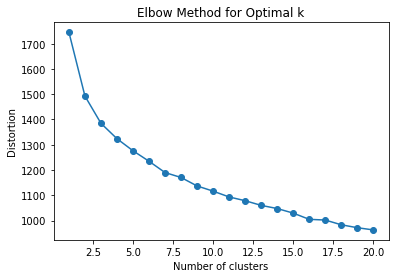

In [33]:
# Elbow Method to determine the optimal number of clusters
distortions = []
max_clusters = 20  # You can adjust this based on your expectations
for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(mean_embeddings_np)
    distortions.append(kmeans.inertia_)

# Plot the elbow graph
plt.plot(range(1, max_clusters + 1), distortions, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [34]:
# Choose the optimal number of clusters based on the plot
optimal_num_clusters = 32#int(input("Enter the optimal number of clusters based on the elbow method: "))

# Perform clustering with the chosen number of clusters
kmeans = KMeans(n_clusters=optimal_num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(mean_embeddings_np)

# Add cluster labels to the DataFrame
df['Cluster'] = cluster_labels
df = df.reset_index(drop=True)
df['Issue Number'] = df['Issue Number'].astype(int)

# Display the DataFrame with cluster labels
df

/home/okg21/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Repo Owner,Repo Name,Issue Title,Issue Body,Author,Assignees,Comments,Labels,Issue State,Issue Number,References,Combined Text,Cluster
0,ckeditor,ckeditor5,There should be an empty paragraph in the newl...,"When you create an editor, but not call `setDa...",pjasiun,[],"[{'body': 'As a matter of fact, that paragraph...","['resolution:duplicate', 'type:improvement']",CLOSED,331,[],There should be an empty paragraph in the newl...,30
1,ckeditor,ckeditor5,Typings for TypeScript,"Hi,\r\n\r\nI'm currently using ckeditor5 in Ty...",ssougnez,[],"[{'body': ""Quoting myself from https://github....","['type:feature', 'support:2', 'squad:core']",CLOSED,504,"[11704, 504]","Typings for TypeScript Hi,\r\n\r\nI'm currentl...",14
2,ckeditor,ckeditor5,Table feature,We plan to bootstrap the table feature very so...,Reinmar,['jodator'],[{'body': 'One of the first things we have to ...,"['type:feature', 'domain:accessibility']",CLOSED,610,[],Table feature We plan to bootstrap the table f...,16
3,ckeditor,ckeditor5,Style feature,I would like to propose the **Styles** feature...,fredck,[],"[{'body': 'As much as I understand the idea, I...","['status:discussion', 'type:feature', 'support...",OPEN,648,[],Style feature I would like to propose the **St...,5
4,ckeditor,ckeditor5,Feature Request: Cycle Through List Styles on ...,"Rather than supporting ""ordered list"" and ""ord...",duracell80,[],[{'body': '> This isn\'t something a designer ...,['resolution:duplicate'],CLOSED,1028,[],Feature Request: Cycle Through List Styles on ...,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,ckeditor,ckeditor5,Drag by balloon block toolbar improvements,As we implemented the new drag behavior by bal...,Witoso,[],[],"['type:improvement', 'package:clipboard', 'squ...",OPEN,15058,[],Drag by balloon block toolbar improvements As ...,21
174,ckeditor,ckeditor5,Find issues matching criteria to mark them as ...,## Provide a description of the task\r\n\r\nTh...,pomek,['psmyrek'],"[{'body': '@psmyrek, could we add a dry mode t...","['type:task', 'squad:devops', 'package:dev', '...",OPEN,15400,[15399],Find issues matching criteria to mark them as ...,26
175,ckeditor,ckeditor5,Determine if stale issues need an action (clos...,## Provide a description of the task\n\nThe go...,pomek,['psmyrek'],[],"['type:task', 'squad:devops', 'package:dev', '...",OPEN,15401,[15399],Determine if stale issues need an action (clos...,26
176,ckeditor,ckeditor5,Create an executable script for the stale bot,## Provide a description of the task\n\nThe go...,pomek,['psmyrek'],[],"['type:task', 'squad:devops', 'package:dev']",OPEN,15402,[15399],Create an executable script for the stale bot ...,11


In [35]:
# Calculate the centroids for each cluster to use later for assigning new-coming issues
centroid_arr = []
for i in range(optimal_num_clusters):
    idx_arr = df[df['Cluster']==i].index
    centroid = np.zeros_like(mean_embeddings_np[0])
    for idx in idx_arr:
        centroid += mean_embeddings_np[idx]
    centroid /= len(idx_arr)
    centroid_arr.append(centroid)
centroid_arr = np.array(centroid_arr)

In [36]:
# Save the centroids
import pickle
with open(name + '_centroid_arr.pkl', 'wb') as f:
  pickle.dump(centroid_arr, f)

In [37]:
# Construct ground truth
gt = [0] * df.shape[0]
df['GroundTruthCluster'] = [0] * df.shape[0]
for i in range(epic_df.shape[0]):
    for j in epic_df.iloc[i]['References']:
        print(df[df['Issue Number'] == int(j)].index)
        print(j)
        gt[(df[df['Issue Number'] == int(j)].index).astype(int)[0]] = i

df['GroundTruthCluster'] = gt

Int64Index([0], dtype='int64')
331
Int64Index([4], dtype='int64')
1028
Int64Index([5], dtype='int64')
1031
Int64Index([73], dtype='int64')
8666
Int64Index([74], dtype='int64')
8712
Int64Index([19], dtype='int64')
6119
Int64Index([15], dtype='int64')
6114
Int64Index([41], dtype='int64')
6353
Int64Index([24], dtype='int64')
6125
Int64Index([28], dtype='int64')
6150
Int64Index([31], dtype='int64')
6284
Int64Index([40], dtype='int64')
6348
Int64Index([34], dtype='int64')
6301
Int64Index([29], dtype='int64')
6151
Int64Index([14], dtype='int64')
6113
Int64Index([27], dtype='int64')
6128
Int64Index([38], dtype='int64')
6346
Int64Index([33], dtype='int64')
6297
Int64Index([35], dtype='int64')
6328
Int64Index([30], dtype='int64')
6154
Int64Index([17], dtype='int64')
6116
Int64Index([37], dtype='int64')
6343
Int64Index([32], dtype='int64')
6285
Int64Index([18], dtype='int64')
6118
Int64Index([26], dtype='int64')
6127
Int64Index([39], dtype='int64')
6347
Int64Index([36], dtype='int64')
6330
Int64

In [38]:
# Check df with cluster ground truth included
df

,Repo Owner,Repo Name,Issue Title,Issue Body,Author,Assignees,Comments,Labels,Issue State,Issue Number,References,Combined Text,Cluster,GroundTruthCluster
0,ckeditor,ckeditor5,There should be an empty paragraph in the newl...,"When you create an editor, but not call `setDa...",pjasiun,[],"[{'body': 'As a matter of fact, that paragraph...","['resolution:duplicate', 'type:improvement']",CLOSED,331,[],There should be an empty paragraph in the newl...,30,0
1,ckeditor,ckeditor5,Typings for TypeScript,"Hi,\r\n\r\nI'm currently using ckeditor5 in Ty...",ssougnez,[],"[{'body': ""Quoting myself from https://github....","['type:feature', 'support:2', 'squad:core']",CLOSED,504,"[11704, 504]","Typings for TypeScript Hi,\r\n\r\nI'm currentl...",14,21
2,ckeditor,ckeditor5,Table feature,We plan to bootstrap the table feature very so...,Reinmar,['jodator'],[{'body': 'One of the first things we have to ...,"['type:feature', 'domain:accessibility']",CLOSED,610,[],Table feature We plan to bootstrap the table f...,16,5
3,ckeditor,ckeditor5,Style feature,I would like to propose the **Styles** feature...,fredck,[],"[{'body': 'As much as I understand the idea, I...","['status:discussion', 'type:feature', 'support...",OPEN,648,[],Style feature I would like to propose the **St...,5,7
4,ckeditor,ckeditor5,Feature Request: Cycle Through List Styles on ...,"Rather than supporting ""ordered list"" and ""ord...",duracell80,[],[{'body': '> This isn\'t something a designer ...,['resolution:duplicate'],CLOSED,1028,[],Feature Request: Cycle Through List Styles on ...,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,ckeditor,ckeditor5,Drag by balloon block toolbar improvements,As we implemented the new drag behavior by bal...,Witoso,[],[],"['type:improvement', 'package:clipboard', 'squ...",OPEN,15058,[],Drag by balloon block toolbar improvements As ...,21,31
174,ckeditor,ckeditor5,Find issues matching criteria to mark them as ...,## Provide a description of the task\r\n\r\nTh...,pomek,['psmyrek'],"[{'body': '@psmyrek, could we add a dry mode t...","['type:task', 'squad:devops', 'package:dev', '...",OPEN,15400,[15399],Find issues matching criteria to mark them as ...,26,32
175,ckeditor,ckeditor5,Determine if stale issues need an action (clos...,## Provide a description of the task\n\nThe go...,pomek,['psmyrek'],[],"['type:task', 'squad:devops', 'package:dev', '...",OPEN,15401,[15399],Determine if stale issues need an action (clos...,26,32
176,ckeditor,ckeditor5,Create an executable script for the stale bot,## Provide a description of the task\n\nThe go...,pomek,['psmyrek'],[],"['type:task', 'squad:devops', 'package:dev']",OPEN,15402,[15399],Create an executable script for the stale bot ...,11,32


In [39]:
# Calculate TP, TN, FP, FN
TP=0
TN=0
FP=0
FN=0
for i in range(df.shape[0]-1):
    for j in range(i+1, df.shape[0]):
        if df.iloc[i]['Cluster'] == df.iloc[j]['Cluster'] and df.iloc[i]['GroundTruthCluster'] == df.iloc[j]['GroundTruthCluster']:
            TP += 1
        elif df.iloc[i]['Cluster'] != df.iloc[j]['Cluster'] and df.iloc[i]['GroundTruthCluster'] != df.iloc[j]['GroundTruthCluster']:
            TN += 1
        elif df.iloc[i]['Cluster'] == df.iloc[j]['Cluster'] and df.iloc[i]['GroundTruthCluster'] != df.iloc[j]['GroundTruthCluster']:
            FP += 1
        elif df.iloc[i]['Cluster'] != df.iloc[j]['Cluster'] and df.iloc[i]['GroundTruthCluster'] == df.iloc[j]['GroundTruthCluster']:
            FN += 1
        else:
            print('Error: Unexpected case')
print('TP: ', TP)
print('TN: ', TN)
print('FP: ', FP)
print('FN: ', FN)

TP:  118
TN:  14229
FP:  573
FN:  833


In [40]:
# Evaluation of the performance of clustering using Rand Index
rand_index = (TP + TN) / (TP + TN + FP + FN)
print('Rand Index Value: ', rand_index)

Rand Index Value:  0.9107471592712499


Since most of the pairs of issues should not be in the same cluster (since the epics contain very small amount of sub-issues), it might not be the best idea to use the Rand Index for evaluating the performance of our clustering. However, it seems good.

In [42]:
#save the clustered data
df.to_csv('data/clustered_data_' + name + '.csv', index=False)
#save the epic data
epic_df.to_csv('data/epic_data_' + name + '.csv', index=False)